<a href="https://colab.research.google.com/github/NitaniK/seq2seq/blob/main/c2s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/30
5/5 [==============================] - 3s 10ms/step - loss: 0.6243
Epoch 2/30
5/5 [==============================] - 0s 9ms/step - loss: 0.5882
Epoch 3/30
5/5 [==============================] - 0s 8ms/step - loss: 0.5553
Epoch 4/30
5/5 [==============================] - 0s 8ms/step - loss: 0.5280
Epoch 5/30
5/5 [==============================] - 0s 9ms/step - loss: 0.5007
Epoch 6/30
5/5 [==============================] - 0s 11ms/step - loss: 0.4772
Epoch 7/30
5/5 [==============================] - 0s 8ms/step - loss: 0.4544
Epoch 8/30
5/5 [==============================] - 0s 8ms/step - loss: 0.4346
Epoch 9/30
5/5 [==============================] - 0s 8ms/step - loss: 0.4173
Epoch 10/30
5/5 [==============================] - 0s 8ms/step - loss: 0.4004
Epoch 11/30
5/5 [==============================] - 0s 9ms/step - loss: 0.3852
Epoch 12/30
5/5 [==============================] - 0s 8ms/step - loss: 0.3722
Epoch 13/30
5/5 [==============================] - 0s 7ms/step - loss: 

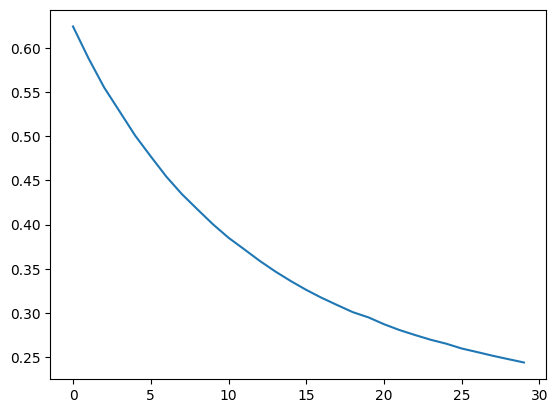

1/1 [==============================] - 0s 31ms/step


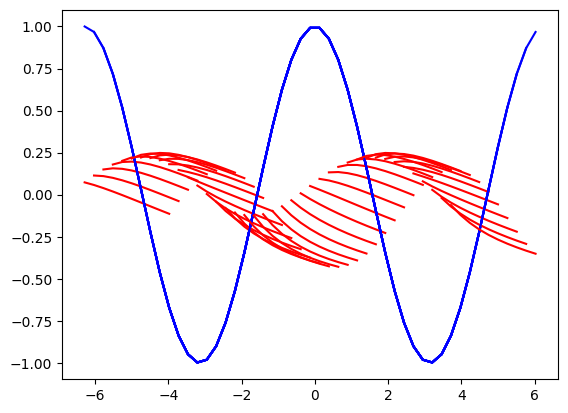

In [11]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, LSTM, Input

x_ax = np.linspace(-2*np.pi, 2*np.pi) # -2πから2πまでの50つの値
cos_data = np.cos(x_ax)
sin_data = np.sin(x_ax)

n_rnn = 10 # 時系列の数
n_sample = len(x_ax) - n_rnn # サンプル数
x_encoder = np.zeros((n_sample, n_rnn)) # encoderの入力
x_decoder = np.zeros((n_sample, n_rnn)) # decoderの入力
t_decoder = np.zeros((n_sample, n_rnn)) # decoderの正解

for i in range(0, n_sample):
	x_encoder[i] = cos_data[i:i+n_rnn]
	x_decoder[i, 1:] = sin_data[i:i+n_rnn-1]

for j in range(0, n_sample):
	t_decoder[j] = sin_data[j:j+n_rnn]

x_encoder = x_encoder.reshape(n_sample, n_rnn, 1)  # （サンプル数、時系列の数、入力層のニューロン数）
x_decoder = x_decoder.reshape(n_sample, n_rnn, 1)
t_decoder = t_decoder.reshape(n_sample, n_rnn, 1)
n_in = 1  # 入力層のニューロン数
n_mid = 20  # 中間層のニューロン数
n_out = n_in  # 出力層のニューロン数

encoder_input = Input(shape=(n_rnn, n_in))
encoder_lstm = LSTM(n_mid, return_state=True)

encoder_output, encoder_state_h, encoder_state_c = encoder_lstm(encoder_input)
encoder_state = [encoder_state_h, encoder_state_c]
decoder_input = Input(shape=(n_rnn, n_in))
decoder_lstm = LSTM(n_mid, return_sequences=True, return_state=True)
decoder_output, _, _ = decoder_lstm(decoder_input, initial_state=encoder_state )
decoder_dense = Dense(n_out, activation='linear')
decoder_output = decoder_dense(decoder_output)

model = Model([encoder_input, decoder_input], decoder_output)
model.compile(loss="mean_squared_error", optimizer="sgd")
history = model.fit([x_encoder, x_decoder], t_decoder,
                     batch_size=8,
                     epochs=30)
loss = history.history['loss']
plt.plot(np.arange(len(loss)), loss)
plt.show()
encoder_model = Model(encoder_input, encoder_state)


#ここから下が推論モデルの構築
decoder_input = Input(shape=(1, n_in))
decoder_state_in_h = Input(shape=(n_mid,))
decoder_state_in_c = Input(shape=(n_mid,))
decoder_state_in = [decoder_state_in_h, decoder_state_in_c]

decoder_output, decoder_state_h, decoder_state_c = decoder_lstm(decoder_input, initial_state=decoder_state_in)

decoder_state = [decoder_state_h, decoder_state_c]
decoder_output = decoder_dense(decoder_output)

decoder_model = Model([decoder_input] + decoder_state_in, [decoder_output] + decoder_state)
def translate(input_data):
  translated = []
  state_value = encoder_model.predict(input_data)
  y_decoder = np.zeros((1,1,1))

  for i in range(0,n_rnn):
    y,h,c = decoder_model.predict([y_decoder] + state_value)
    y = y[0][0][0]
    translated.append(y)
    y_decoder[0][0][0] = y
    state_value = [h,c]
  return translated
idices = range(0, 40)
for indice in idices:
    x = x_encoder[indice:indice+1]  # 入力を一部取り出す
    y = translate(x)

    plt.plot(x_ax[indice:indice+n_rnn], x.reshape(-1), color="b")  # 翻訳前を青い線
    plt.plot(x_ax[indice:indice+n_rnn], y, color="r")  # 翻訳後は赤い線

plt.show()






